In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model
from classes import *
from tensorflow.keras.applications.vgg19 import VGG19
import keras_tuner
# Limit GPU's memory growth rate to avoid OOM errors
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0],True)

hello world


In [2]:
path = 'C:\\Users\\gupta\\OneDrive\\Desktop\\celeb\\dataset_faces\\'
dataset_high = tf.keras.utils.image_dataset_from_directory(directory=path+'high_dataset',
                                                        labels=None,
                                                        batch_size=None,
                                                        image_size=(128,128),
                                                        interpolation='bicubic',
                                                        shuffle=False
)
# dataset_high = dataset_high.map(lambda x: x/255.)
resize = tf.keras.layers.Resizing(32,32,interpolation='bicubic')
dataset_low = dataset_high.map(lambda x: resize(x))
dataset = tf.data.Dataset.zip(datasets=(dataset_low,dataset_high))

Found 50000 files belonging to 1 classes.


In [ ]:
# epochs to train the generator before the actual GAN training
warmup_epochs = 5
# epochs to train the GAN
epochs = 25
# Out of 50k images, select the number of images you want to train the SRGAN on
dataset_size = 3000
# Select the batch size (My machine can go upto 16 at max)
batch_size = 8
# Make the dataset according to the above set hyperparameters
dataset_train = dataset.take(dataset_size).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
# Calculate the steps based on dataset_size and batch_size
steps_float = dataset_size/batch_size
steps_per_epoch = int(steps_float) if int(steps_float) == steps_float else int(steps_float)+1

# Optimizers for generator and discriminator
gen_optim = tf.keras.optimizers.Adam()
dis_optim = tf.keras.optimizers.Adam()

# Instantiate Generator, Discriminator, VGGloss and binarycrossentropy
generator = Generator()
discriminator = Discriminator()
vgg22 = VGGloss()
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

for epoch in range(1,warmup_epochs+epochs+1):
    # Print the number of current epoch
    if epoch in range(1,warmup_epochs+1):
        print(f"Warming Up the Generator, Epoch {epoch}/{warmup_epochs}:")
    else:
        print(f"Training SRGAN, Epoch {epoch-warmup_epochs}/{epochs}:")
    
    for step, (low_res, high_res) in enumerate(dataset_train):
        # Getting the super res image by passing the low res into the generator
        super_res = generator(low_res,training=True)
        
        if epoch not in range(1,warmup_epochs+1):
            # Training the Discriminator
            with tf.GradientTape() as tape1:
                # Getting the opinion of the discriminator on the high res and super res
                dis_super_res = discriminator(super_res,training=True)
                dis_high_res = discriminator(high_res,training=True)

                # Get the binarycrossentropy loss between the discriminator's opinion of super and high res and the actual label
                real_score = binary_crossentropy(tf.ones(shape=tf.shape(dis_high_res)) - 0.1 * tf.random.normal(shape=tf.shape(dis_high_res),mean=0,stddev=0.166667),dis_high_res)
                fake_score = binary_crossentropy(tf.zeros(shape=tf.shape(dis_super_res)) + 0.1 * tf.random.normal(shape=tf.shape(dis_super_res),mean=0,stddev=0.166667),dis_super_res)

                discriminator_loss = real_score + fake_score
            # Get the gradients and apply them onto the discriminator's trainable weights
            discriminator_gradients = tape1.gradient(discriminator_loss,discriminator.trainable_weights)
            dis_optim.apply_gradients(zip(discriminator_gradients,discriminator.trainable_weights))

        # Training the Generator
        with tf.GradientTape() as tape2:
            # Get the super res again so that GradientTape can record it
            super_res = generator(low_res, training=True)
            dis_super_res = discriminator(super_res, training=True)

            # Get the MSE loss between the output features super res and high res from VGG19
            content_loss = vgg22(super_res,high_res)
            # Getting the loss on how well the generator can fool the discriminator
            adverserial_loss = 1e-3 * (binary_crossentropy(tf.ones(shape=tf.shape(dis_super_res)),dis_super_res))

            generator_loss = content_loss + adverserial_loss
            # Get the gradients and apply them onto the generator's trainable weights
        generator_gradients = tape2.gradient(generator_loss,generator.trainable_weights)
        gen_optim.apply_gradients(zip(generator_gradients,generator.trainable_weights))

        # Print the loss and steps done at the end of each step
        if epoch in range(1,warmup_epochs+1):
            print(f"Step Counter: {step+1}/{steps_per_epoch} | Generator loss: {generator_loss}", end='\r' if step+1!=steps_per_epoch else '\n')
        else:
            print(f"Step Counter: {step+1}/{steps_per_epoch} | Generator loss: {generator_loss} | Discriminator loss: {discriminator_loss}", end='\r' if step+1!=steps_per_epoch else '\n')

In [ ]:
class TuneHyperparameters(keras_tuner.HyperModel):
    def build(self, hp):
        # Instantiate the Generator and Discriminator
        self.generator = Generator()
        self.discriminator = Discriminator()
        # Returning a dummy model because the fit function only accepts a model which is a instance of the class tf.keras.Model
        input = tf.keras.layers.Input(shape=(1,1))
        output = tf.keras.layers.Dense(units=1)(input)
        return tf.keras.Model(input,output)

    def fit(self, hp, model, dataset, **kwargs):
            '''
            Run the usual training loop, comments for each individual line are written in the above cell
            '''
            warmup_epochs = 5
            epochs = 25
            dataset_size = 3000
            batch_size = hp.Choice('batch_size',[8,16])
            dataset_train = dataset.take(dataset_size).batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
            steps_float = dataset_size/batch_size
            steps_per_epoch = int(steps_float) if int(steps_float) == steps_float else int(steps_float)+1

            # Optimizers for generator and discriminator
            gen_optim = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate_generator', 1e-4,1e-2,sampling='log',default=1e-3))
            dis_optim = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate_discriminator', 1e-4,1e-2,sampling='log',default=1e-3))

            # Instantiate VGGloss and binarycrossentropy
            vgg = VGGloss(choice='22')
            binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
            
            # Set all the callback's 'model' attribute to model (I honestly don't know what this does but it works!!)
            for callback in kwargs['callbacks']:
                callback.model = model

            best_loss = float('inf')

            for epoch in range(1,warmup_epochs+epochs+1):
                if epoch in range(1,warmup_epochs+1):
                    print(f"Warming Up the Generator, Epoch {epoch}/{warmup_epochs}:")
                else:
                    print(f"Training SRGAN, Epoch {epoch-warmup_epochs}/{epochs}:")

                for step, (low_res, high_res) in enumerate(dataset_train):
                    super_res = self.generator(low_res,training=True)
                    if epoch not in range(1,warmup_epochs+1):
                        # Training the Discriminator
                        with tf.GradientTape() as tape1:
                            dis_super_res = self.discriminator(super_res,training=True)
                            dis_high_res = self.discriminator(high_res,training=True)

                            real_score = binary_crossentropy(tf.ones(shape=tf.shape(dis_high_res)) - 0.1 * tf.random.normal(shape=tf.shape(dis_high_res),mean=0,stddev=0.166667),dis_high_res)
                            fake_score = binary_crossentropy(tf.zeros(shape=tf.shape(dis_super_res)) + 0.1 * tf.random.normal(shape=tf.shape(dis_super_res),mean=0,stddev=0.166667),dis_super_res)

                            discriminator_loss = abs(real_score) + abs(fake_score)
                        discriminator_gradients = tape1.gradient(discriminator_loss,self.discriminator.trainable_weights)
                        dis_optim.apply_gradients(zip(discriminator_gradients,self.discriminator.trainable_weights))

                    # Training the Generator
                    with tf.GradientTape() as tape2:
                        super_res = self.generator(low_res, training=True)
                        dis_super_res = self.discriminator(super_res, training=True)

                        content_loss = hp.Float('content_weight',0.001,1,default=0.006) * vgg(super_res,high_res)
                        adverserial_loss = hp.Float('adverserial_weight',0.0001,0.01) * (binary_crossentropy(tf.ones(shape=tf.shape(dis_super_res)),dis_super_res))

                        generator_loss = content_loss + adverserial_loss
                    generator_gradients = tape2.gradient(generator_loss,self.generator.trainable_weights)
                    gen_optim.apply_gradients(zip(generator_gradients,self.generator.trainable_weights))
                    

                    if epoch in range(1,warmup_epochs+1):
                        print(f"Step Counter: {step+1}/{steps_per_epoch} | Generator loss: {generator_loss}", end='\r' if step+1!=steps_per_epoch else '\n')
                    else:
                        print(f"Step Counter: {step+1}/{steps_per_epoch} | Generator loss: {generator_loss} | Discriminator loss: {discriminator_loss}", end='\r' if step+1!=steps_per_epoch else '\n')

                # Set when to call the callback (at the end of each epoch)
                for callback in kwargs['callbacks']:
                    callback.on_epoch_end(epoch, logs={'generator_loss': generator_loss})
                
                # Maintain the best and minimum loss
                best_loss = min(best_loss,generator_loss)

            return best_loss.numpy()
    

# Instantiate the tuner and pass the created class in the `hypermodel` argument
tuner = keras_tuner.RandomSearch(
    objective=keras_tuner.Objective("generator_loss", "min"),
    max_trials=20,
    executions_per_trial=1,
    hypermodel=TuneHyperparameters(),
    directory="results",
    project_name="custom_training",
    overwrite=True,
)
# Begin the search
tuner.search(dataset)

In [3]:
generator = Generator()
discriminator = Discriminator()
# build the generator and discriminator on the correct shapes before loading in the weights
generator.build(input_shape=(1,32,32,3))
discriminator.build(input_shape=(1,128,128,3))

# Load the saved weights into the generator and discriminator
generator.load_weights('Project checkpoints\\5_25_epochs_8_bs_3k_dataset_notnormalised_labelsmoothing\\generator.h5')
discriminator.load_weights('Project checkpoints\\5_25_epochs_8_bs_3k_dataset_notnormalised_labelsmoothing\\discriminator.h5')

Found 89 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'HIGH RESOLUTION IMAGE')

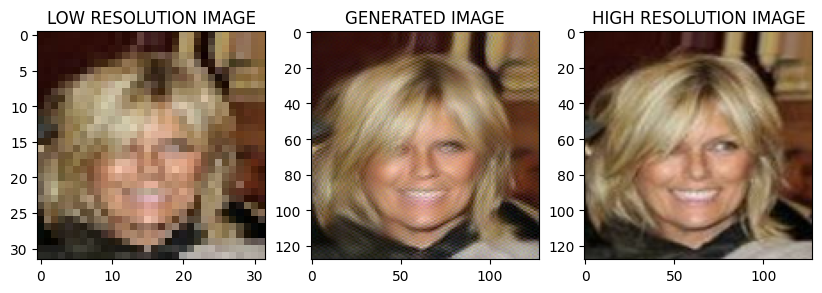

In [4]:
# Import the dataset of high resolution images from the directory
dataset_test_high = tf.keras.utils.image_dataset_from_directory(directory='C:\\Users\\gupta\\OneDrive\\Desktop\\celeb\\dataset_faces\\test_dataset',
                                                        labels=None,
                                                        batch_size=None,
                                                        image_size=(128,128),
                                                        interpolation='bicubic',
                                                        shuffle=False
)
# Resize all the high resolution images to low resolution images
dataset_test_low = dataset_test_high.map(lambda x: tf.keras.layers.Resizing(32,32,interpolation='bicubic')(x))
# Convert both the datasets to tuples for indexing and slicing
dataset_test_high = tuple(dataset_test_high)
dataset_test_low = tuple(dataset_test_low)
# Create 3 subplots to plot lowres,highres,superres
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,10))
# Select a random integer and use it as a index 
idx = np.random.randint(0,len(dataset_test_high))
# Show all the images and set the title
ax1.imshow(dataset_test_low[idx]/255)
ax1.set_title('LOW RESOLUTION IMAGE')
ax2.imshow(tf.squeeze(generator(tf.expand_dims(dataset_test_low[idx],axis=0)))/255)
ax2.set_title('GENERATED IMAGE')
ax3.imshow(dataset_test_high[idx]/255)
ax3.set_title('HIGH RESOLUTION IMAGE')

In [ ]:
# Get the best hyperparameters after searching
best = tuner.get_best_hyperparameters()[0]
print(best.values)